# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [74]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import tensorflow as tf
from pathlib import Path
#from skspatial.objects import Vector
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [97]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#files = ["/global/cfs/cdirs/m3712/Mu2e/TARef_v7.root:TAReM/trkana"]
files = ["/Users/brownd/data/TARef_40.root:TAReM/trkana"]

up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
upmc_px = []
upmc_py = []
upmc_pz = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []
nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trkfit|trkmcsim/i",report=True):
    print("Fields available in 'trkfit':", ak.fields(batch["trkfit"]))
    # upstream and downstream tracks
    upstream = batch["trkfit"][:,0]
    downstream = batch["trkfit"][:,1]
    print("uspstream ",len(upstream)," downstream ",len(downstream))
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.sum(up_up,axis=1) > 0
    has_up_down = ak.sum(up_down,axis=1) > 0
    has_down_down = ak.sum(down_down,axis=1) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up = up_up[has_all]
    up_down = up_down[has_all]
    down_down = down_down[has_all]
 #   print("has_all ",len(has_up_up),len(has_up_down),len(has_down_down),len(has_all))
#    #print("has_all ",ak.num(has_up_up,axis=1),ak.num(has_up_down,axis=1),ak.num(has_down_down,axis=1),ak.num(has_all,axis=1))
#    print("nums axis=0", ak.num(up_up, axis=0), ak.num(up_down, axis=0), ak.num(down_down, axis=0))
#    print("nums axis=1", ak.num(up_up, axis=1), ak.num(up_down, axis=1), ak.num(down_down, axis=1))
#    print("masked", ak.num(upstream[has_all], axis=0), ak.num(upstream[has_all], axis=1))
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))                      
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    uptrkmcsim = uptrkmcsim[has_all]
    downtrkmcsim = downtrkmcsim[has_all]
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))
    
    nipaup = batch["trk.nipaup"][:,0] # only need upstream track for material intersection counting
    nipadown = batch["trk.nipadown"][:,0]
    nstup = batch["trk.nstup"][:,0]
    nstdown = batch["trk.nstdown"][:,0]
    nipaup = nipaup[has_all]
    nipadown = nipadown[has_all]
    nstup = nstup[has_all]
    nstdown = nstdown[has_all]
    
    nipa_up.extend(nipaup)
    nipa_down.extend(nipadown)
    nst_up.extend(nstup)    
    nst_down.extend(nstdown)
    

deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

up_mom2 = np.square(up_px) + np.square(up_py) + np.square(up_pz)
up_mom = np.sqrt(up_mom2)
down_mom2 = np.square(down_px) + np.square(down_py) + np.square(down_pz)
down_mom = np.sqrt(down_mom2)

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",len(up_mom),up_mom[:10])
print("Downstream momentum ",len(down_mom),down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())
print("nmat ",len(nmat))
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])


Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  620  downstream  620
Upstream momentum  620 [119.97287 160.70534 144.82304  71.4271  114.67609 109.20267  70.25603
 118.6301  160.59303 208.8143 ]
Downstream momentum  620 [119.918564 160.44295  144.20593   71.3048   113.65323  109.10495
  69.3771   118.23601  159.33357  208.70456 ]
Upstream fit upstream time  620 [954.0272601377251, 1126.914243275761, 967.1776214213636, 1598.8896747416184, 999.5253660508512, 1213.657824671043, 574.9385222073411, 1229.8626972899826, 584.739591472153, 555.7598170393402]
Upstream fit downstream time 620 [1005.2322295453971, 1179.31969093127, 1020.6453936715335, 1651.260201561405, 1048.456111694931, 1276.465983008212, 632.6945314069778, 1276.5491062819754, 645.3118042251954, 622.9573700395806]
Downstream fit downstream time 620 [1006.1302571003565, 1178.724002654787, 1020.7059354098619, 1651.3841696727445, 1047.99096107796

Label true elec

In [98]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])


True Electrons 620 [ True  True  True  True  True  True  True  True False False]
True Muons 620 [False False False False False False False False  True  True]


N true electrons  540  N true muons  80


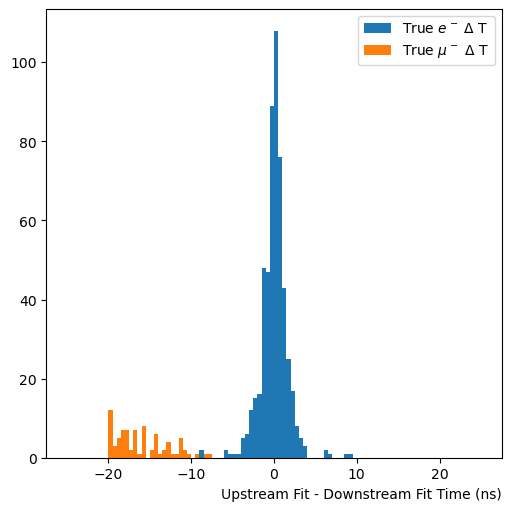

In [99]:
time_diff = np.subtract(up_down_time,down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
ehist = ax.hist(em_time_diff,label="True $e^-$ $\Delta$ T", bins=100,range=(-25,25))
muhist = ax.hist(mum_time_diff,label="True $\mu^-$ $\Delta$ T", bins=100,range=(-25,25))
ax.set_xlabel('Upstream Fit - Downstream Fit Time (ns)',loc='right')
ax.legend()

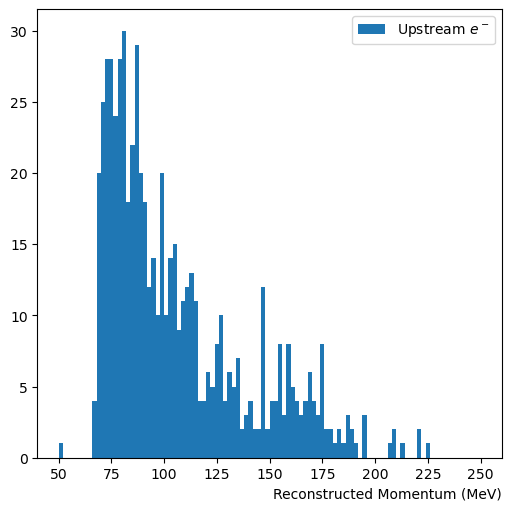

In [100]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
uphist = ax.hist(up_mom,label="Upstream $e^-$", bins=100,range=(50,250))
ax.set_xlabel('Reconstructed Momentum (MeV)',loc='right')
ax.legend()

In [101]:
abs_time_diff = np.absolute(time_diff)
good_em = []
max_tdiff = 5.0
for tdiff in abs_time_diff :
    good_em.append( tdiff <  max_tdiff)
print("Good electron ",len(good_em),good_em[:10])
good_em = np.array(good_em)
true_good_em = good_em[true_em]
eff = good_em.sum()/true_em.sum()
pur = true_good_em.sum()/good_em.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good electron  620 [True, True, True, True, True, True, True, True, False, False]
For Delta T <  5.0  efficiency =  0.9722222222222222  purity =  1.0


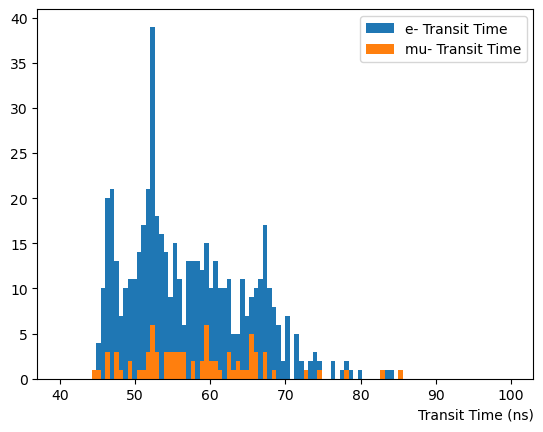

In [102]:
transit_time = np.subtract(up_down_time,up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,100))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,100))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

highp  620
nomat  620


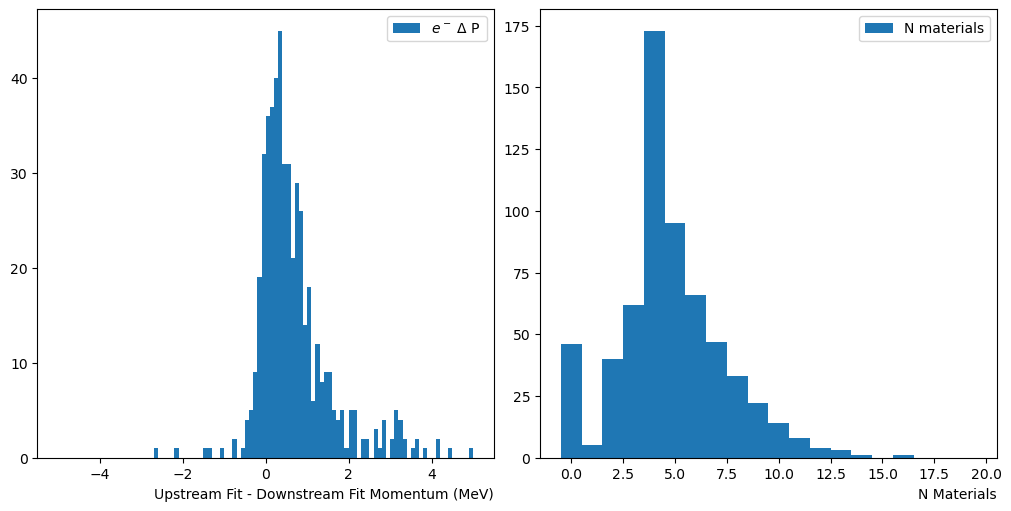

In [108]:
mom_diff = np.subtract(up_mom,down_mom)
nomat = []
for nm in nmat :
    nomat.append( nm <4 )
print("highp ",len(highp))
print("nomat ",len(nomat))
good_em_nomat = np.logical_and(nomat,good_em)

em_mom_diff = mom_diff[good_em]
em_mom_diff_nomat = mom_diff[good_em_nomat]
nmat_good = nmat[good_em]
up_mom_good = up_mom[good_em]

fig, (ax0, ax1 )  = plt.subplots(1,2,layout='constrained', figsize=(10,5))
ax0.hist(em_mom_diff,label="$e^-$ $\Delta$ P",bins=100,range=(-5,5))
ax0.set_xlabel("Upstream Fit - Downstream Fit Momentum (MeV)",loc='right')
ax0.legend()
#ax1.hist(em_mom_diff_nomat,label="$e^-$ $\Delta$ P",bins=100,range=(-10,10))
#ax1.set_xlabel("Upstream Fit - Downstream Fit Momentum (MeV)",loc='right')
#ax1.legend()
ax1.hist(nmat,label="N materials",bins=20,range=(-0.5,19.5))
ax1.set_xlabel("N Materials",loc='right')
ax1.legend()
#ax1.hist2d(nmat_good,em_mom_diff,bins=(15,100),range=([0,15],[-5,5]),norm=mpl.colors.LogNorm())
#ax1.set_xlabel("N Material Xings",loc='right')
#ax1.set_ylabel("Delta P (MeV)",loc='top')
#ax2.hist2d(up_mom_good,em_mom_diff,bins=(20,100),range=([40,150],[-5,5]),norm=mpl.colors.LogNorm())
#ax2.set_xlabel("Upstream P (MeV)",loc='right')
#ax2.set_ylabel("Delta P (MeV)",loc='top')